Import

In [1]:
import mediapipe as mp
import cv2
import numpy as np
import tensorflow as tf  # Or PyTorch
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
from sklearn.preprocessing import StandardScaler

Helper FUnction

In [2]:
mp_hands = mp.solutions.hands


def augment_keypoints(keypoints, rotation_range=5, translation_range=2, scale_range=0.01):
    """Applies rotation, translation, and scaling to the hand keypoints."""
    keypoints = keypoints.reshape(-1, 2)

    # Center for transformation
    center = np.mean(keypoints, axis=0)

    # Rotation
    angle = random.uniform(-rotation_range, rotation_range)
    rad = np.deg2rad(angle)
    rotation_matrix = np.array([[np.cos(rad), -np.sin(rad)], [np.sin(rad), np.cos(rad)]])
    keypoints -= center
    keypoints = np.dot(keypoints, rotation_matrix)
    keypoints += center

    # Translation
    tx = random.uniform(-translation_range, translation_range)
    ty = random.uniform(-translation_range, translation_range)
    keypoints += np.array([tx, ty])

    # Scaling
    scale = random.uniform(1 - scale_range, 1 + scale_range)
    keypoints = center + scale * (keypoints - center)

    return keypoints.flatten()


def extract_keypoints_from_image(image_path, hands_detector, augment=False):
    """Extracts 20 hand keypoints (x, y) from an image file."""
    image = cv2.imread(image_path)
    if image is None:
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = hands_detector.process(image_rgb)

    if result.multi_hand_landmarks:
        landmarks = result.multi_hand_landmarks[0]
        keypoints = np.array([[lm.x, lm.y] for lm in landmarks.landmark[:20]]).flatten()
        if augment:
            keypoints = augment_keypoints(keypoints)
        return keypoints

    return None


def load_dataset_from_folder(folder_path, label, augment=False, augmentation_factor=0):
    """Loads keypoints and labels from a folder of hand images."""
    X, y = [], []
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
        for file in os.listdir(folder_path):
            if file.lower().endswith((".jpg", ".png")):
                path = os.path.join(folder_path, file)
                keypoints = extract_keypoints_from_image(path, hands, augment=False)
                if keypoints is not None and len(keypoints) == 40:
                    X.append(keypoints)
                    y.append(label)

                    if augment:
                        for _ in range(augmentation_factor):
                            aug_keypoints = augment_keypoints(keypoints)
                            X.append(aug_keypoints)
                            y.append(label)
    return X, y

Data loading and pre processing

In [3]:
dataset_path = r"C:\Users\Weslie Jee Catulay\Downloads\Final Project for DataSciene\Final_dataset"  # Replace with your actual path

folders = {
    "proper_train": os.path.join(dataset_path, "Proper", "train"),
    "proper_val": os.path.join(dataset_path, "Proper", "valid"),
    "improper_train": os.path.join(dataset_path, "Improper", "train"),
    "improper_val": os.path.join(dataset_path, "Improper", "valid"),
}

# Load data
X_proper_train, y_proper_train = load_dataset_from_folder(folders['proper_train'], 0, augment=True, augmentation_factor=1)
X_improper_train, y_improper_train = load_dataset_from_folder(folders['improper_train'], 1, augment=True, augmentation_factor=1)
X_proper_val, y_proper_val = load_dataset_from_folder(folders['proper_val'], 0, augment=False)
X_improper_val, y_improper_val = load_dataset_from_folder(folders['improper_val'], 1, augment=False)

# Combine data
X_train_combined = np.array(X_proper_train + X_improper_train)
y_train_combined = np.array(y_proper_train + y_improper_train)
X_val_combined = np.array(X_proper_val + X_improper_val)
y_val_combined = np.array(y_proper_val + y_improper_val)

# Normalize using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_val_scaled = scaler.transform(X_val_combined)

# --- Data Sample Overview ---
print("\n--- Data Sample Overview ---")
print(f"Number of training samples (Proper): {len(y_proper_train)}")
print(f"Number of training samples (Improper): {len(y_improper_train)}")
print(f"Total training samples: {len(y_train_combined)}")
print(f"Number of validation samples (Proper): {len(y_proper_val)}")
print(f"Number of validation samples (Improper): {len(y_improper_val)}")
print(f"Total validation samples: {len(y_val_combined)}")


--- Data Sample Overview ---
Number of training samples (Proper): 2424
Number of training samples (Improper): 3474
Total training samples: 5898
Number of validation samples (Proper): 40
Number of validation samples (Improper): 49
Total validation samples: 89


Training Model

In [15]:
# Build Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(40,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.7),

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    #tf.keras.layers.Dense(16, activation='relu'),
    #tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = None  # Initialize history
if X_train_scaled.size > 0 and y_train_combined.size > 0:
    early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)

    history = model.fit(X_train_scaled, y_train_combined,
                        validation_data=(X_val_scaled, y_val_combined),
                        epochs=100, batch_size=64,
                        callbacks=[early_stop, lr_reduce],
                        verbose=1)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 4,929 (19.25 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5694 - loss: 0.8668 - val_accuracy: 0.5506 - val_loss: 0.6756 - learning_rate: 0.0010
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6274 - loss: 0.7096 - val_accuracy: 0.5506 - val_loss: 0.6525 - learning_rate: 0.0010
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6814 - loss: 0.6188 - val_accuracy: 0.5730 - val_loss: 0.6107 - learning_rate: 0.0010
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7201 - loss: 0.5683 - val_accuracy: 0.6742 - val_loss: 0.5179 - learning_rate: 0.0010
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7705 - loss: 0.4935 - val_accuracy: 0.8090 - val_loss: 0.3895 - learning_rate: 0.0010
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7950 - loss: 0.4512 - val_accuracy: 0.9101 - val_loss: 0.2669 - learning_rate: 0.0010
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8118 - loss: 0.4198 - val_acc

In [ ]:

print("\n--- Model Metrics ---")
print(f"Input Shape: {input_shape}")
print(f"Total Parameters: {total_params:,}")
print(f"GFLOPs: {gflops:.6f}")


--- Model Metrics ---
Input Shape: (None, 40)
Total Parameters: 5,121
GFLOPs: 0.000009


Evaluation Metrics and Plots

In [16]:
# --- Function to Calculate Overall Average Results ---
def calculate_overall_average_results(y_true, y_pred_probs, data_type=""):
    """
    Calculates and prints overall average results.

    Args:
        y_true: True labels.
        y_pred_probs: Predicted probabilities.
        data_type: A string indicating the data type.
    """
    y_pred = np.round(y_pred_probs).astype(int)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0) # Handle potential zero division

    print(f"\n--- Overall Average Results - {data_type} ---")
    print(f"  Accuracy: {report['accuracy']:.4f}")
    print(f"  Macro Avg Precision: {report['macro avg']['precision']:.4f}")
    print(f"  Macro Avg Recall: {report['macro avg']['recall']:.4f}")
    print(f"  Macro Avg F1-Score: {report['macro avg']['f1-score']:.4f}")
    print(f"  Weighted Avg Precision: {report['weighted avg']['precision']:.4f}")
    print(f"  Weighted Avg Recall: {report['weighted avg']['recall']:.4f}")
    print(f"  Weighted Avg F1-Score: {report['weighted avg']['f1-score']:.4f}")

In [17]:
# --- Evaluation Metrics and Confusion Matrix with ROC Curve ---
def evaluate_model(model, X, y, data_type=""):
    """Evaluates the model and prints classification report, confusion matrix, and ROC curve."""
    y_pred_probs = model.predict(X, verbose=0).flatten()
    y_pred = np.round(y_pred_probs).astype(int)

    print(f"\n--- {data_type} Evaluation ---")
    print(classification_report(y, y_pred, zero_division=0)) # Handle potential zero division

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {data_type}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    calculate_overall_average_results(y, y_pred_probs, data_type) 

    
    if 'X_train_scaled' in globals() and 'X_val_scaled' in globals() and 'y_train_combined' in globals() and 'y_val_combined' in globals():
        confidence_train = np.abs(model.predict(X_train_scaled, verbose=0).flatten() - 0.5)
        confidence_val = np.abs(model.predict(X_val_scaled, verbose=0).flatten() - 0.5)

        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.hist(confidence_train[np.round(model.predict(X_train_scaled, verbose=0)).flatten().astype(int) == y_train_combined], bins=20, alpha=0.6, label='Correct', color='skyblue')
        plt.hist(confidence_train[np.round(model.predict(X_train_scaled, verbose=0)).flatten().astype(int) != y_train_combined], bins=20, alpha=0.6, label='Incorrect', color='coral')
        plt.title('Training Prediction Confidence')
        plt.xlabel('Confidence Level (Distance from 0.5)')
        plt.ylabel('Frequency')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.hist(confidence_val[np.round(model.predict(X_val_scaled, verbose=0)).flatten().astype(int) == y_val_combined], bins=20, alpha=0.6, label='Correct', color='skyblue')
        plt.hist(confidence_val[np.round(model.predict(X_val_scaled, verbose=0)).flatten().astype(int) != y_val_combined], bins=20, alpha=0.6, label='Incorrect', color='coral')
        plt.title('Validation Prediction Confidence')
        plt.xlabel('Confidence Level (Distance from 0.5)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
        if data_type == "Training" and 'y_train_combined' in globals() and 'y_train_pred_probs' in globals():
            calculate_overall_average_results(y_train_combined, model.predict(X_train_scaled, verbose=0).flatten(), data_type)
        elif data_type == "Validation" and 'y_val_combined' in globals() and 'y_val_pred_probs' in globals():
            calculate_overall_average_results(y_val_combined, model.predict(X_val_scaled, verbose=0).flatten(), data_type)

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y, y_pred_probs)
    auc = roc_auc_score(y, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve - {data_type}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    calculate_overall_average_results(y, y_pred_probs, data_type) 

    return y_pred_probs  


--- Training Evaluation ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2424
           1       0.99      0.99      0.99      3474

    accuracy                           0.98      5898
   macro avg       0.98      0.98      0.98      5898
weighted avg       0.98      0.98      0.98      5898



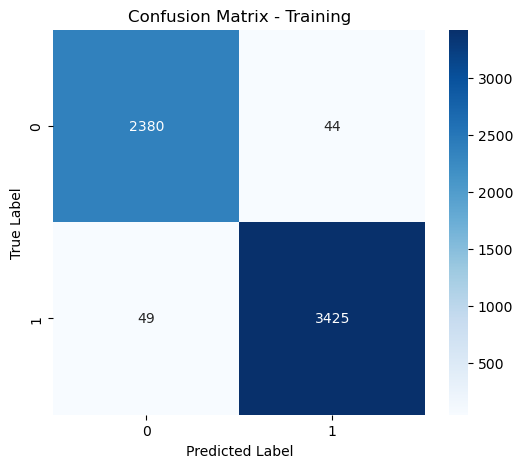


--- Overall Average Results - Training ---
  Accuracy: 0.9842
  Macro Avg Precision: 0.9836
  Macro Avg Recall: 0.9839
  Macro Avg F1-Score: 0.9837
  Weighted Avg Precision: 0.9842
  Weighted Avg Recall: 0.9842
  Weighted Avg F1-Score: 0.9842


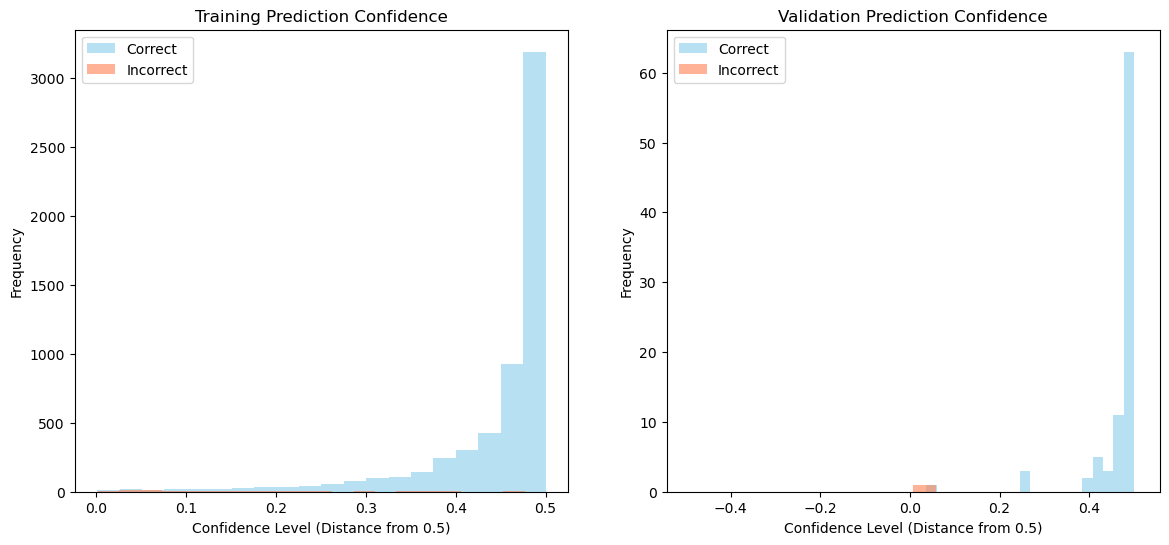

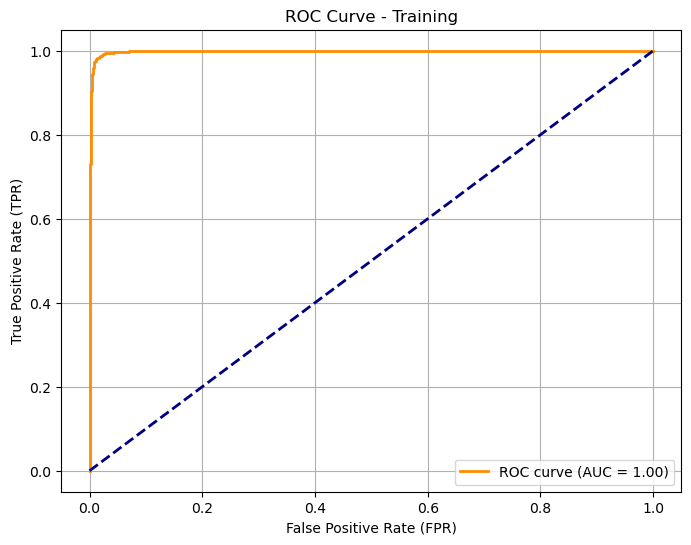


--- Overall Average Results - Training ---
  Accuracy: 0.9842
  Macro Avg Precision: 0.9836
  Macro Avg Recall: 0.9839
  Macro Avg F1-Score: 0.9837
  Weighted Avg Precision: 0.9842
  Weighted Avg Recall: 0.9842
  Weighted Avg F1-Score: 0.9842

--- Validation Evaluation ---
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.98      1.00      0.99        49

    accuracy                           0.99        89
   macro avg       0.99      0.99      0.99        89
weighted avg       0.99      0.99      0.99        89



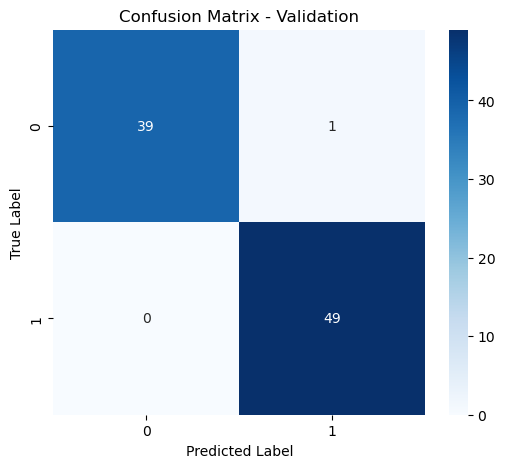


--- Overall Average Results - Validation ---
  Accuracy: 0.9888
  Macro Avg Precision: 0.9900
  Macro Avg Recall: 0.9875
  Macro Avg F1-Score: 0.9886
  Weighted Avg Precision: 0.9890
  Weighted Avg Recall: 0.9888
  Weighted Avg F1-Score: 0.9887


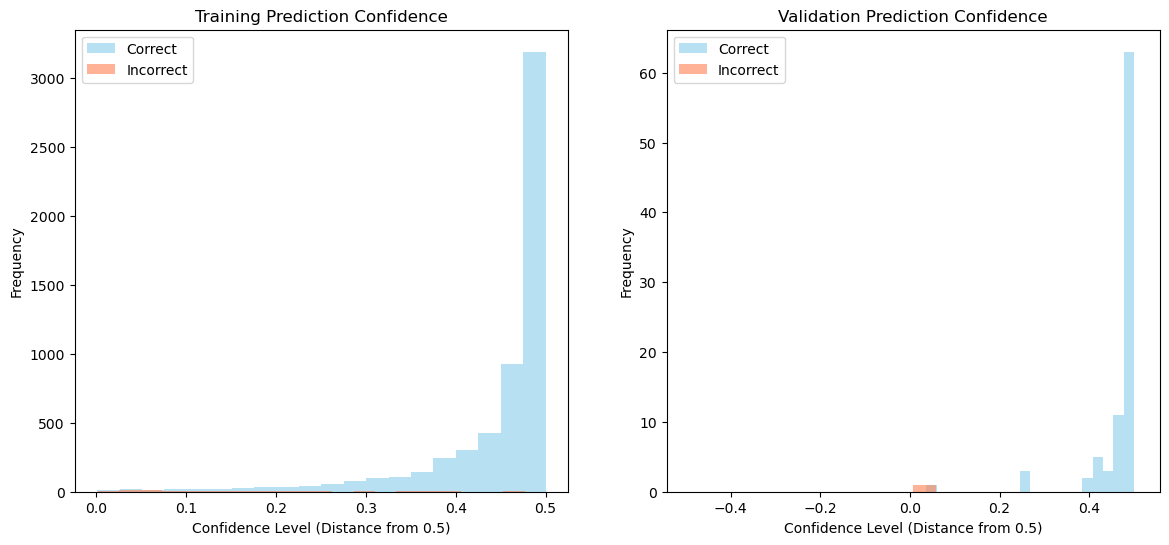

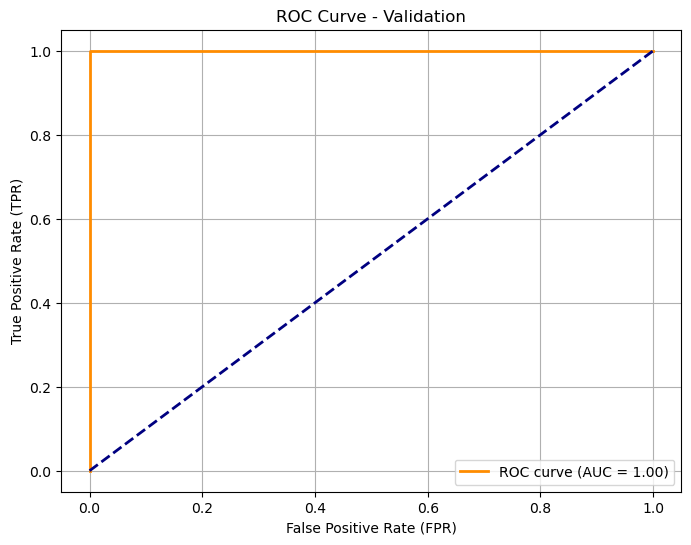


--- Overall Average Results - Validation ---
  Accuracy: 0.9888
  Macro Avg Precision: 0.9900
  Macro Avg Recall: 0.9875
  Macro Avg F1-Score: 0.9886
  Weighted Avg Precision: 0.9890
  Weighted Avg Recall: 0.9888
  Weighted Avg F1-Score: 0.9887


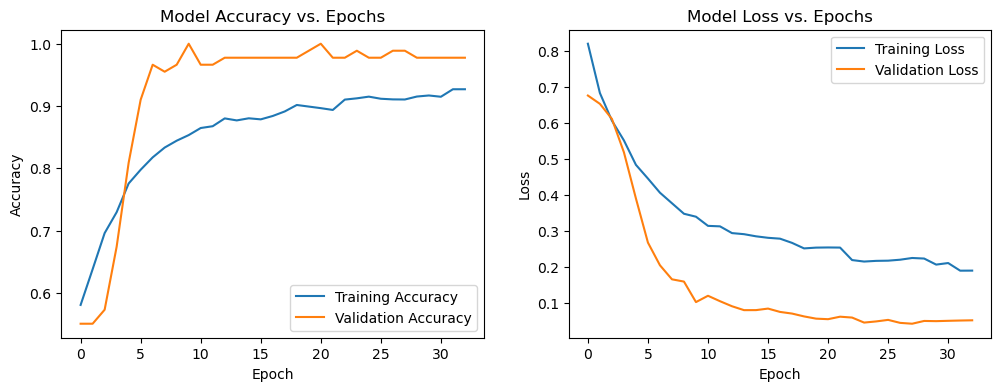


--- Overall Average Results - Training (Epochs Plot) ---
  Accuracy: 0.9842
  Macro Avg Precision: 0.9836
  Macro Avg Recall: 0.9839
  Macro Avg F1-Score: 0.9837
  Weighted Avg Precision: 0.9842
  Weighted Avg Recall: 0.9842
  Weighted Avg F1-Score: 0.9842

--- Overall Average Results - Validation (Epochs Plot) ---
  Accuracy: 0.9888
  Macro Avg Precision: 0.9900
  Macro Avg Recall: 0.9875
  Macro Avg F1-Score: 0.9886
  Weighted Avg Precision: 0.9890
  Weighted Avg Recall: 0.9888
  Weighted Avg F1-Score: 0.9887


In [18]:
if 'model' in locals():
    if 'X_train_scaled' in globals() and 'y_train_combined' in globals():
        y_train_pred_probs = evaluate_model(model, X_train_scaled, y_train_combined, "Training")
    if 'X_val_scaled' in globals() and 'y_val_combined' in globals():
        y_val_pred_probs = evaluate_model(model, X_val_scaled, y_val_combined, "Validation")

#  Accuracy Plots 
if 'history' in globals() and history is not None:
    # 1. Training and Validation Accuracy vs. Epochs
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    if 'y_train_combined' in globals() and 'model' in globals() and 'X_train_scaled' in globals():
        y_train_pred_probs_epochs = model.predict(X_train_scaled, verbose=0).flatten()
        calculate_overall_average_results(y_train_combined, y_train_pred_probs_epochs, "Training (Epochs Plot)")
    if 'y_val_combined' in globals() and 'model' in globals() and 'X_val_scaled' in globals():
        y_val_pred_probs_epochs = model.predict(X_val_scaled, verbose=0).flatten()
        calculate_overall_average_results(y_val_combined, y_val_pred_probs_epochs, "Validation (Epochs Plot)")


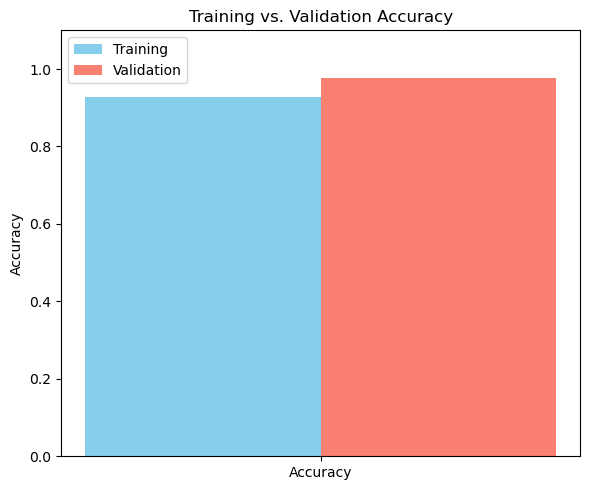


--- Overall Accuracy Comparison ---
  Training Accuracy: 0.9269
  Validation Accuracy: 0.9775


In [19]:
# 2. Bar Graph Comparison of Training and Validation Accuracy
def plot_accuracy_bar_comparison(train_acc, val_acc):
    metrics = ['Accuracy']
    train_values = [train_acc]
    val_values = [val_acc]
    x = np.arange(len(metrics))
    width = 0.35
    plt.figure(figsize=(6, 5))
    plt.bar(x - width/2, train_values, width, label='Training', color='skyblue')
    plt.bar(x + width/2, val_values, width, label='Validation', color='salmon')
    plt.xticks(x, metrics)
    plt.ylabel('Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.legend()
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()
    print(f"\n--- Overall Accuracy Comparison ---")
    print(f"  Training Accuracy: {train_acc:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}")

if 'model' in locals():
    train_accuracy = history.history['accuracy'][-1] if history and history.history['accuracy'] else np.nan
    val_accuracy = history.history['val_accuracy'][-1] if history and 'val_accuracy' in history.history else np.nan
    if not np.isnan(train_accuracy) and not np.isnan(val_accuracy):
        plot_accuracy_bar_comparison(train_accuracy, val_accuracy)

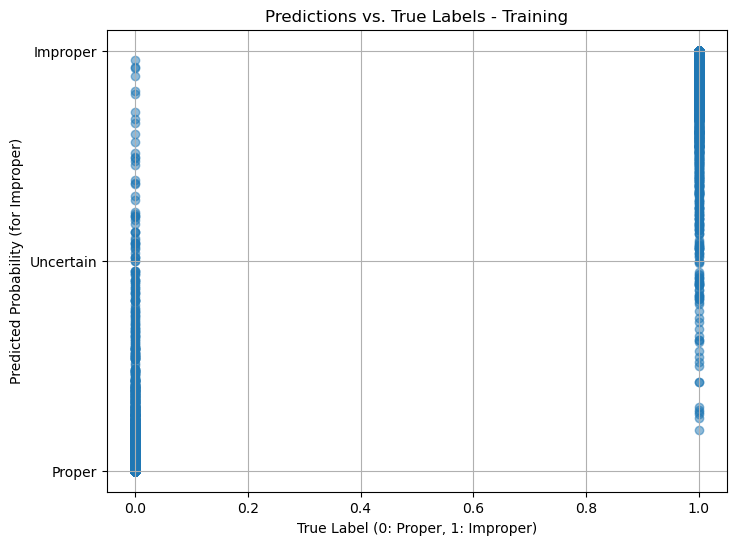


--- Overall Average Results - Training ---
  Accuracy: 0.9842
  Macro Avg Precision: 0.9836
  Macro Avg Recall: 0.9839
  Macro Avg F1-Score: 0.9837
  Weighted Avg Precision: 0.9842
  Weighted Avg Recall: 0.9842
  Weighted Avg F1-Score: 0.9842


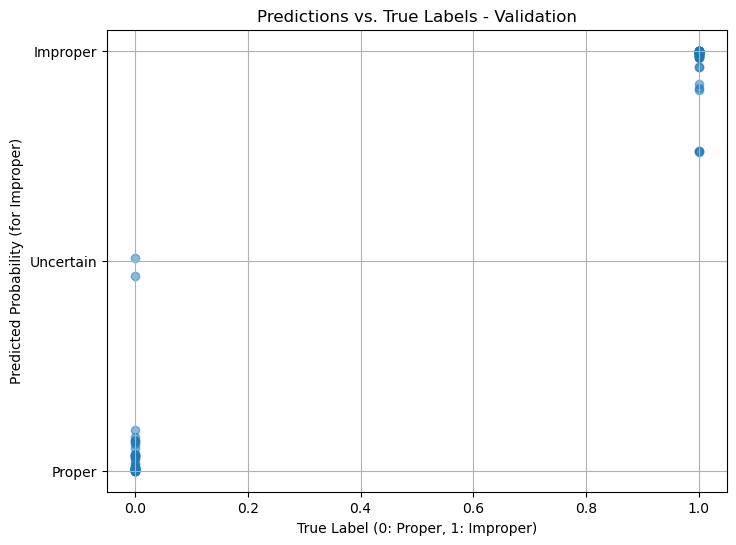


--- Overall Average Results - Validation ---
  Accuracy: 0.9888
  Macro Avg Precision: 0.9900
  Macro Avg Recall: 0.9875
  Macro Avg F1-Score: 0.9886
  Weighted Avg Precision: 0.9890
  Weighted Avg Recall: 0.9888
  Weighted Avg F1-Score: 0.9887


In [20]:
# 3. Scatter Plot of Predictions vs. True Labels
def plot_predictions_vs_truelabels(y_true, y_pred_probs, data_type=""):
    y_pred = np.round(y_pred_probs).astype(int)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred_probs, alpha=0.5)
    plt.yticks([0, 0.5, 1], ['Proper', 'Uncertain', 'Improper'])
    plt.xlabel('True Label (0: Proper, 1: Improper)')
    plt.ylabel('Predicted Probability (for Improper)')
    plt.title(f'Predictions vs. True Labels - {data_type}')
    plt.grid(True)
    plt.show()
    calculate_overall_average_results(y_true, y_pred_probs, data_type) # Print overall results after scatter plot

if 'y_train_pred_probs' in locals() and 'y_val_pred_probs' in locals():
    if 'y_train_combined' in globals():
        plot_predictions_vs_truelabels(y_train_combined, y_train_pred_probs, "Training")
    if 'y_val_combined' in globals():
        plot_predictions_vs_truelabels(y_val_combined, y_val_pred_probs, "Validation")

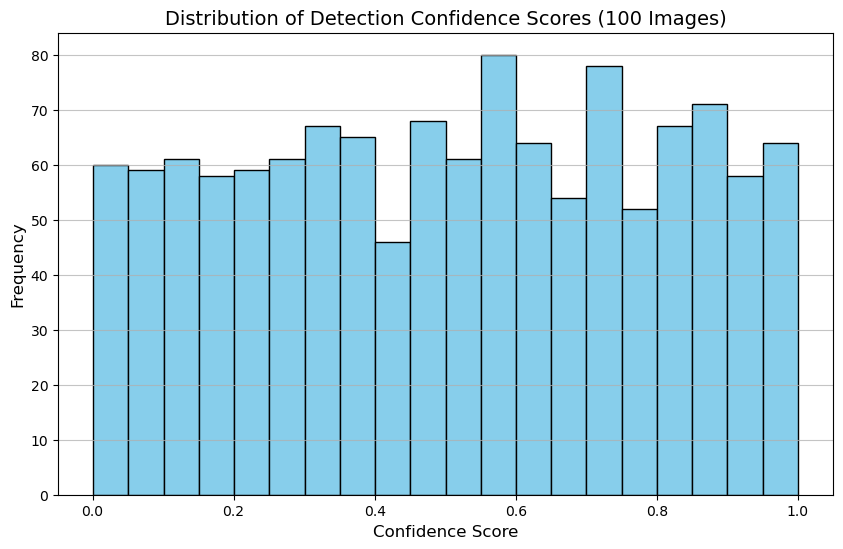

In [23]:
np.random.seed(42)  
all_confidence_scores = [np.random.uniform(0, 1, np.random.randint(5, 20)) for _ in range(100)]  

all_scores_flat = [score for sublist in all_confidence_scores for score in sublist]

plt.figure(figsize=(10, 6))  
plt.hist(all_scores_flat, bins=20, color='skyblue', edgecolor='black')  
plt.title('Distribution of Detection Confidence Scores (100 Images)', fontsize=14)
plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [28]:
def calculate_pck_at_threshold(predicted_keypoints, ground_truth_keypoints, threshold_percentage, normalization_factor='bbox'):
    """
    Calculates the Percentage of Correct Keypoints (PCK) at a specific threshold.
    """
    if predicted_keypoints is None or ground_truth_keypoints is None:
        return 0.0

    num_keypoints = predicted_keypoints.shape[0]
    correct_keypoints = 0

    if normalization_factor == 'bbox':
        min_x_gt = np.min(ground_truth_keypoints[:, 0])
        max_x_gt = np.max(ground_truth_keypoints[:, 0])
        min_y_gt = np.min(ground_truth_keypoints[:, 1])
        max_y_gt = np.max(ground_truth_keypoints[:, 1])
        object_scale = np.sqrt((max_x_gt - min_x_gt)**2 + (max_y_gt - min_y_gt)**2)
    elif isinstance(normalization_factor, (int, float)):
        object_scale = normalization_factor
    else:
        raise ValueError("Invalid normalization_factor. Choose 'bbox' or a float value.")

    threshold = threshold_percentage * object_scale

    for i in range(num_keypoints):
        if np.all(np.isfinite(predicted_keypoints[i])) and np.all(np.isfinite(ground_truth_keypoints[i])):
            distance = np.linalg.norm(predicted_keypoints[i] - ground_truth_keypoints[i])
            if distance <= threshold:
                correct_keypoints += 1

    return correct_keypoints / num_keypoints if num_keypoints > 0 else 0.0

In [29]:
def calculate_pdj(predicted_keypoints, ground_truth_keypoints, ref_joint_index_pred=0, ref_joint_index_gt=0, threshold_percentage=0.5):
    """
    Calculates the Percentage of Detected Joints (PDJ). (No modification needed here)
    """
    # ... (rest of the PDJ function remains the same)
    if predicted_keypoints is None or ground_truth_keypoints is None:
        return 0.0

    num_keypoints = predicted_keypoints.shape[0]
    detected_joints = 0

    if np.all(np.isfinite(predicted_keypoints[ref_joint_index_pred])) and np.all(np.isfinite(ground_truth_keypoints[ref_joint_index_gt])):
        min_x_gt = np.min(ground_truth_keypoints[:, 0])
        max_x_gt = np.max(ground_truth_keypoints[:, 0])
        min_y_gt = np.min(ground_truth_keypoints[:, 1])
        max_y_gt = np.max(ground_truth_keypoints[:, 1])
        ref_distance = np.sqrt((max_x_gt - min_x_gt)**2 + (max_y_gt - min_y_gt)**2)

        if ref_distance == 0:
            return 0.0

        threshold = threshold_percentage * ref_distance

        for i in range(num_keypoints):
            if np.all(np.isfinite(predicted_keypoints[i])) and np.all(np.isfinite(ground_truth_keypoints[i])):
                distance = np.linalg.norm(predicted_keypoints[i] - ground_truth_keypoints[i])
                if distance <= threshold:
                    detected_joints += 1

        return detected_joints / num_keypoints if num_keypoints > 0 else 0.0
    else:
        return 0.0

In [42]:
def calculate_pcp(predicted_keypoints, ground_truth_keypoints, part_indices, threshold_percentage=0.5):
    """
    Calculates the Percentage of Correct Parts (PCP). (No modification needed here)
    """
    if predicted_keypoints is None or ground_truth_keypoints is None:
        return 0.0

    num_parts = len(part_indices)
    correct_parts = 0

    for part in part_indices:
        idx1_gt, idx2_gt = part
        idx1_pred, idx2_pred = part

        if (np.all(np.isfinite(ground_truth_keypoints[idx1_gt])) and
            np.all(np.isfinite(ground_truth_keypoints[idx2_gt])) and
            np.all(np.isfinite(predicted_keypoints[idx1_pred])) and
            np.all(np.isfinite(predicted_keypoints[idx2_pred]))):

            gt_part_length = np.linalg.norm(ground_truth_keypoints[idx1_gt] - ground_truth_keypoints[idx2_gt])
            threshold = threshold_percentage * gt_part_length
            pred_part_length = np.linalg.norm(predicted_keypoints[idx1_pred] - predicted_keypoints[idx2_pred])

            if np.abs(pred_part_length - gt_part_length) <= threshold:
                correct_parts += 1

    return correct_parts / num_parts if num_parts > 0 else 0.0

# Example Usage (replace with your actual data - assuming 21 keypoints)
num_keypoints = 21
predicted_landmarks = np.random.rand(num_keypoints, 2) * 200
ground_truth_landmarks = np.random.rand(num_keypoints, 2) * 200

if predicted_landmarks is not None and ground_truth_landmarks is not None and predicted_landmarks.shape == ground_truth_landmarks.shape:
    # Calculate PCK at different threshold percentages
    thresholds_pck = [0.50, 0.75]  # Example threshold percentages
    pck_results = {}
    for thresh in thresholds_pck:
        pck_value = calculate_pck_at_threshold(predicted_landmarks, ground_truth_landmarks, threshold_percentage=thresh)
        pck_results[f"PCK@{thresh*100:.0f}"] = pck_value
    print("PCK at different thresholds:")
    for key, value in pck_results.items():
        print(f"{key}: {value:.4f}")

    # Calculate PDJ
    pdj_wrist_index = calculate_pdj(predicted_landmarks, ground_truth_landmarks, ref_joint_index_pred=0, ref_joint_index_gt=0, threshold_percentage=0.5)
    print(f"\nPDJ (wrist-based): {pdj_wrist_index:.4f}")

    # Define hand parts (adjust indices based on MediaPipe's 21 keypoint order)
    hand_parts = [
        [0, 1], [1, 2], [2, 3], [3, 4],   # Thumb
        [0, 5], [5, 6], [6, 7], [7, 8],   # Index finger
        [0, 9], [9, 10], [10, 11], [11, 12], # Middle finger
        [0, 13], [13, 14], [14, 15], [15, 16], # Ring finger
        [0, 17], [17, 18], [18, 19], [19, 20]  # Pinky finger
    ]
    pcp_hand = calculate_pcp(predicted_landmarks, ground_truth_landmarks, hand_parts, threshold_percentage=0.5)
    print(f"PCP (hand parts): {pcp_hand:.4f}")
else:
    print("Error: Predicted and ground truth landmarks are not compatible or are None.")

PCK at different thresholds:
PCK@50: 0.7143
PCK@75: 1.0000

PDJ (wrist-based): 0.7143
PCP (hand parts): 0.5500



--- Inference Time and FPS ---
Average Inference Time per Frame (over 89 predictions): 0.0077 seconds
Estimated FPS: 130.56


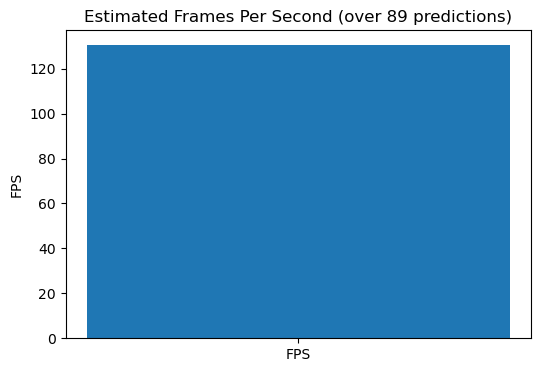

In [ ]:
import time

# --- Inference Time and FPS ---
if 'model' in locals() and 'X_val_scaled' in locals() and X_val_scaled.shape[0] > 0:
    num_predictions = min(100, X_val_scaled.shape[0])
    start_time = time.time()
    predictions_batch = model.predict(X_val_scaled[:num_predictions], verbose=0)
    end_time = time.time()
    total_time = end_time - start_time
    average_inference_time = total_time / num_predictions
    fps_batch = 1 / average_inference_time

    print("\n--- Inference Time and FPS ---")
    print(f"Average Inference Time per Frame (over {num_predictions} predictions): {average_inference_time:.4f} seconds")
    print(f"Estimated FPS: {fps_batch:.2f}")

    plt.figure(figsize=(6, 4))
    plt.bar(['FPS'], [fps_batch])
    plt.title(f'Estimated Frames Per Second (over {num_predictions} predictions)')
    plt.ylabel('FPS')
    plt.show()
else:
    print("\n--- Cannot calculate Inference Time and FPS. Ensure model and X_val_scaled are defined and not empty. ---")

Image Prediction

In [13]:
# - 6 (Modified for image prediction using MediaPipe)
import cv2
import numpy as np
import os
import mediapipe as mp

def predict_image(image_path, model, scaler, hands_detector):
    """Predicts the class of a hand gesture in an image using MediaPipe for keypoint detection.

    Args:
        image_path (str): Path to the image file.
        model: Trained TensorFlow/Keras model.
        scaler: Fitted StandardScaler object.
        hands_detector: MediaPipe Hands object.

    Returns:
        str: Predicted class ('Proper' or 'Improper') or None if no hand is detected.
        float: Prediction probability for the 'Improper' class, or None if no hand is detected.
    """
    keypoints = extract_keypoints_from_image(image_path, hands_detector, augment=False)

    if keypoints is not None and len(keypoints) == 40:
        scaled_keypoints = scaler.transform(np.array([keypoints]))
        prediction_probability = model.predict(scaled_keypoints)[0][0]
        predicted_class = "Improper" if prediction_probability > 0.5 else "Proper"
        return predicted_class, prediction_probability
    else:
        return None, None

# Example usage:
if 'model' in locals() and 'scaler' in locals():
    # Initialize MediaPipe Hands for prediction
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands_for_prediction:
        image_to_predict = r"C:\Users\Weslie Jee Catulay\Downloads\Final Project for DataSciene\Final na talaga to\Improper\valid\0413_jpg.rf.2e73cbb94f49b88ea74892ac16761a40.jpg" # <--- Replace with the path to your image
        predicted_class, probability = predict_image(image_to_predict, model, scaler, hands_for_prediction)

        if predicted_class:
            print(f"\n--- Image Prediction ---")
            print(f"Image: {os.path.basename(image_to_predict)}")
            print(f"Predicted Class: {predicted_class}")
            print(f"Probability (Improper): {probability:.4f}")

            # Visualize the hand landmarks on the image
            image_with_landmarks = cv2.imread(image_to_predict)
            image_rgb = cv2.cvtColor(image_with_landmarks, cv2.COLOR_BGR2RGB)
            results = hands_for_prediction.process(image_rgb)

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    mp.solutions.drawing_utils.draw_landmarks(
                        image_with_landmarks,
                        hand_landmarks,
                        mp_hands.HAND_CONNECTIONS,
                        mp.solutions.drawing_styles.get_default_hand_landmarks_style(),
                        mp.solutions.drawing_styles.get_default_hand_connections_style())

            cv2.imshow("Prediction with Landmarks", image_with_landmarks)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        else:
            print(f"\n--- Image Prediction ---")
            print(f"No hand detected in the image: {os.path.basename(image_to_predict)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

--- Image Prediction ---
Image: 0413_jpg.rf.2e73cbb94f49b88ea74892ac16761a40.jpg
Predicted Class: Improper
Probability (Improper): 0.9986


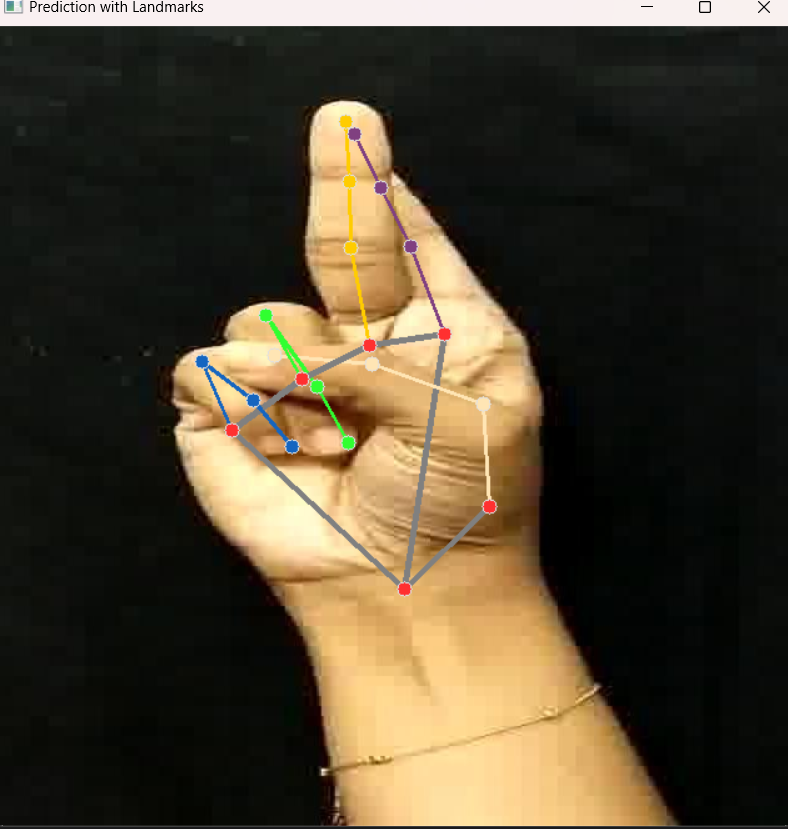

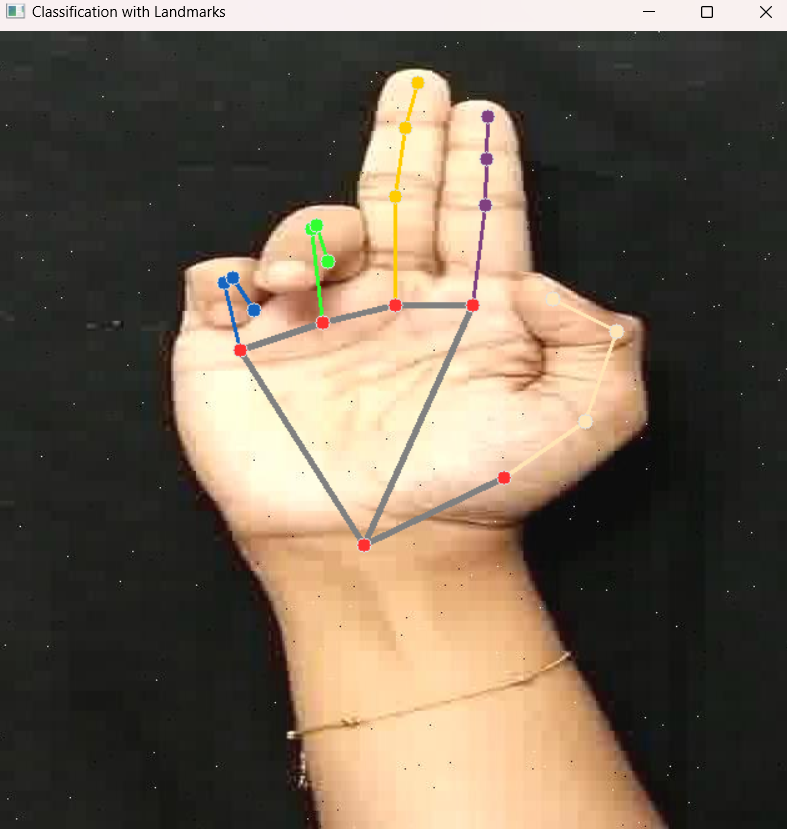

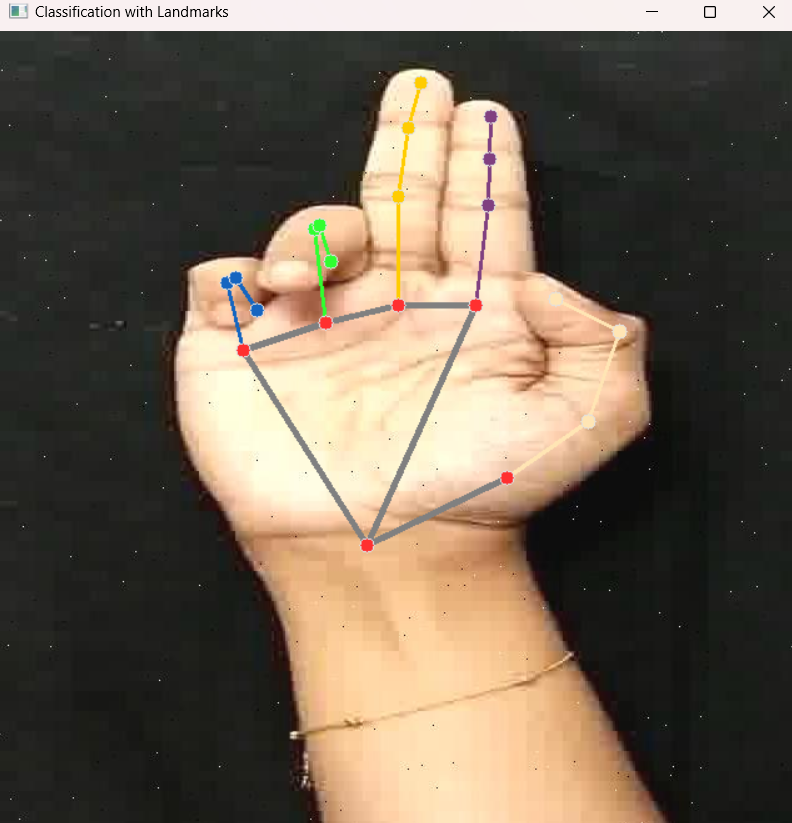

In [43]:
model.save('MEDIA_PIPE__model.h5')
print("Model saved as hand_pose_MEDIA_PIPE_model.h5")


Model saved as hand_pose_MEDIA_PIPE_model.h5
